In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
# from  flame_classification.flame_classification import FCA
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
import random
import sklearn.metrics as metrics
import seaborn as sns

Using TensorFlow backend.


In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

In [3]:
def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        return model

    model = tf.keras.models.Sequential()
    model.add(Input(shape=(74, 74, 1)))
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [4]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 74, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        3

### Open flame type

In [5]:
### flame type data set
with h5py.File('../flame_classification/data//y_flames_classification.h5',
               "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data_y = list(f[a_group_key])

Keys: <KeysViewHDF5 ['Y_data']>


In [6]:
data_y.pop(0)

0

In [42]:
data_y.shape

(5910, 3)

#### Open Images

In [7]:
### image data set
with h5py.File('../flame_classification/data//x_flames_classification.h5', "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data_x = list(f[a_group_key])

Keys: <KeysViewHDF5 ['X_data']>


In [8]:
data_x.pop(0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

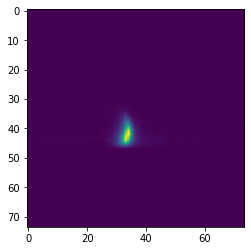

In [9]:
plt.imshow(data_x[-1])

#### Convert images to gray scale

In [10]:
x_data_gray = [((arr - arr.min()) * (1 / (arr.max() - arr.min())))
               for arr in data_x]

In [11]:
x_data_gray[1].shape

(74, 74)

#### Distribution of flame types

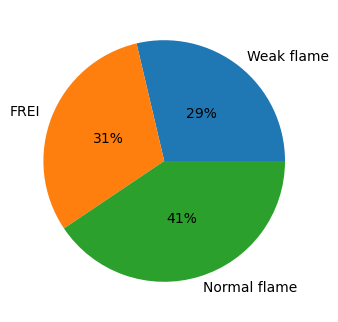

In [12]:
labels = ['Weak flame', 'FREI', 'Normal flame']
occurance_perc = [
    sum([1 for i in data_y if i == 0]) / len(data_y),
    sum([1 for i in data_y if i == 1]) / len(data_y),
    sum([1 for i in data_y if i == 2]) / len(data_y)
]
plt.figure(figsize=(4, 4), dpi=100)
plt.pie(
    occurance_perc,
    labels=labels,
    autopct='%1.0f%%',
    pctdistance=0.5,
    labeldistance=1.1,
);

#### Shuffling the dataset

In [13]:
c = list(zip(x_data_gray, data_y))

random.shuffle(c)

(x_data_gray, data_y) = zip(*c)

data_y = np.asarray(data_y).astype('uint8')

In [14]:
x_data_gray = np.asarray(x_data_gray)

In [15]:
x_data_gray = x_data_gray.reshape(5910, 74, 74,1)

In [16]:
class_names = ['Weak flame', 'FREI', 'Normal Flame']

In [17]:
data_y = tf.keras.utils.to_categorical(data_y)

In [18]:
mm = int(len(x_data_gray) * 0.8)
nn = int(len(x_data_gray) * 0.9)

In [19]:
X_train = x_data_gray[:mm]
X_test = x_data_gray[mm:nn]
X_valid = x_data_gray[nn:]
y_train = data_y[:mm]
y_test = data_y[mm:nn]
y_valid = data_y[nn:]

In [20]:
y_train.shape

(4728, 3)

In [21]:
numb = 42
tf.random.set_seed(numb)

In [41]:
model_history = model.fit(X_train,
                          y_train,
                          epochs=10,
                          validation_data=(X_valid, y_valid))

Train on 4728 samples, validate on 591 samples
Epoch 1/10
4728/4728 [==============================] - 73s 15ms/sample - loss: 0.0382 - accuracy: 0.9903 - val_loss: 0.0396 - val_accuracy: 0.9882
Epoch 2/10
4728/4728 [==============================] - 73s 16ms/sample - loss: 0.0239 - accuracy: 0.9937 - val_loss: 0.0363 - val_accuracy: 0.9898
Epoch 3/10
4728/4728 [==============================] - 73s 16ms/sample - loss: 0.0242 - accuracy: 0.9939 - val_loss: 0.2016 - val_accuracy: 0.9746
Epoch 4/10
4728/4728 [==============================] - 74s 16ms/sample - loss: 0.0386 - accuracy: 0.9911 - val_loss: 4.3467 - val_accuracy: 0.5838
Epoch 5/10
4728/4728 [==============================] - 73s 16ms/sample - loss: 0.0357 - accuracy: 0.9905 - val_loss: 0.0466 - val_accuracy: 0.9882
Epoch 6/10
4728/4728 [==============================] - 73s 16ms/sample - loss: 0.0183 - accuracy: 0.9928 - val_loss: 0.0497 - val_accuracy: 0.9898
Epoch 7/10
4728/4728 [==============================] - 73s 15ms/

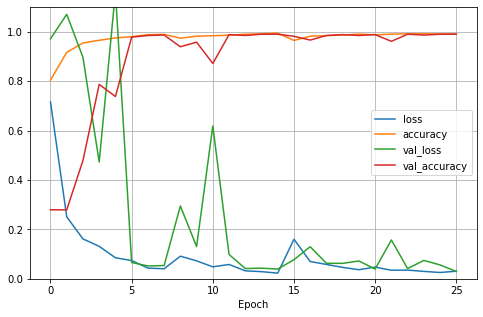

In [23]:

df = pd.DataFrame(model_history.history)
df = df[:26]
df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.1)
plt.xlabel('Epoch')
plt.show()

In [24]:
mpl.rcParams["font.family"] ='serif'
mpl.rcParams["font.size"] =10

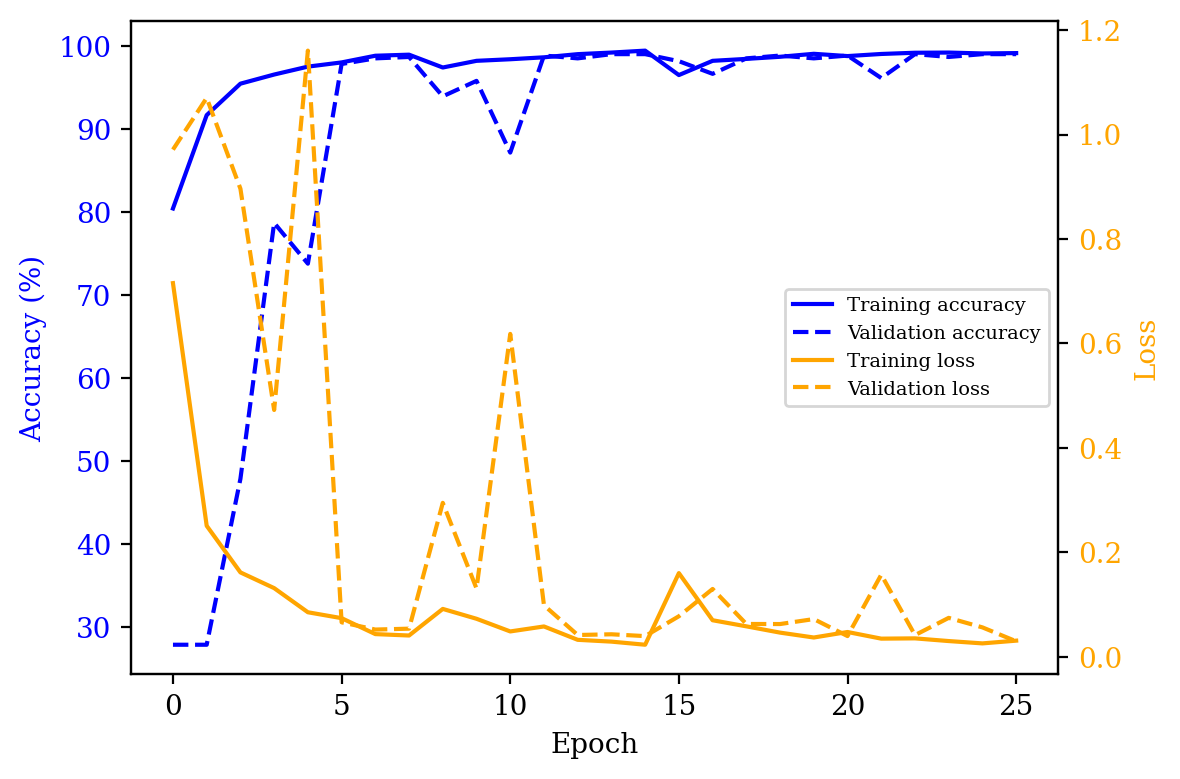

In [25]:
fig, ax1 = plt.subplots(dpi=200)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)',color ='b')
ax1.plot(np.arange(26), df['accuracy']*100, color='b',linestyle='-',label = 'Training accuracy')
ax1.plot(np.arange(26), df['val_accuracy']*100, color='b',linestyle='--',label = 'Validation accuracy')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('Loss',color = 'orange')  # we already handled the x-label with ax1
ax2.plot(np.arange(26), df['loss'], color='orange',linestyle='-',label = 'Training loss')
ax2.plot(np.arange(26), df['val_loss'], color='orange',linestyle='--',label = 'Validation loss')
ax2.tick_params(axis='y', labelcolor='orange')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax1.legend(lines, labels, loc='center right',fontsize = 7)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [26]:
y_pred = model.predict_classes(X_test)

In [27]:
y_pred=tf.keras.utils.to_categorical(y_pred)

In [28]:
y_pred

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [29]:
y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [30]:
sum([1 for i in range(len(y_test)) if sum(abs(y_pred - y_test)[i]) != 0])

155

In [31]:
perc = (len(y_test) -sum([1 for i in range(len(y_test)) if sum(abs(y_pred - y_test)[i]) != 0]))/len(y_test)*100

In [32]:
print('{}% is the accuracy for the test dataset'.format(round(perc, 3)))

73.773% is the accuracy for the test dataset


In [33]:
len(y_test)

591

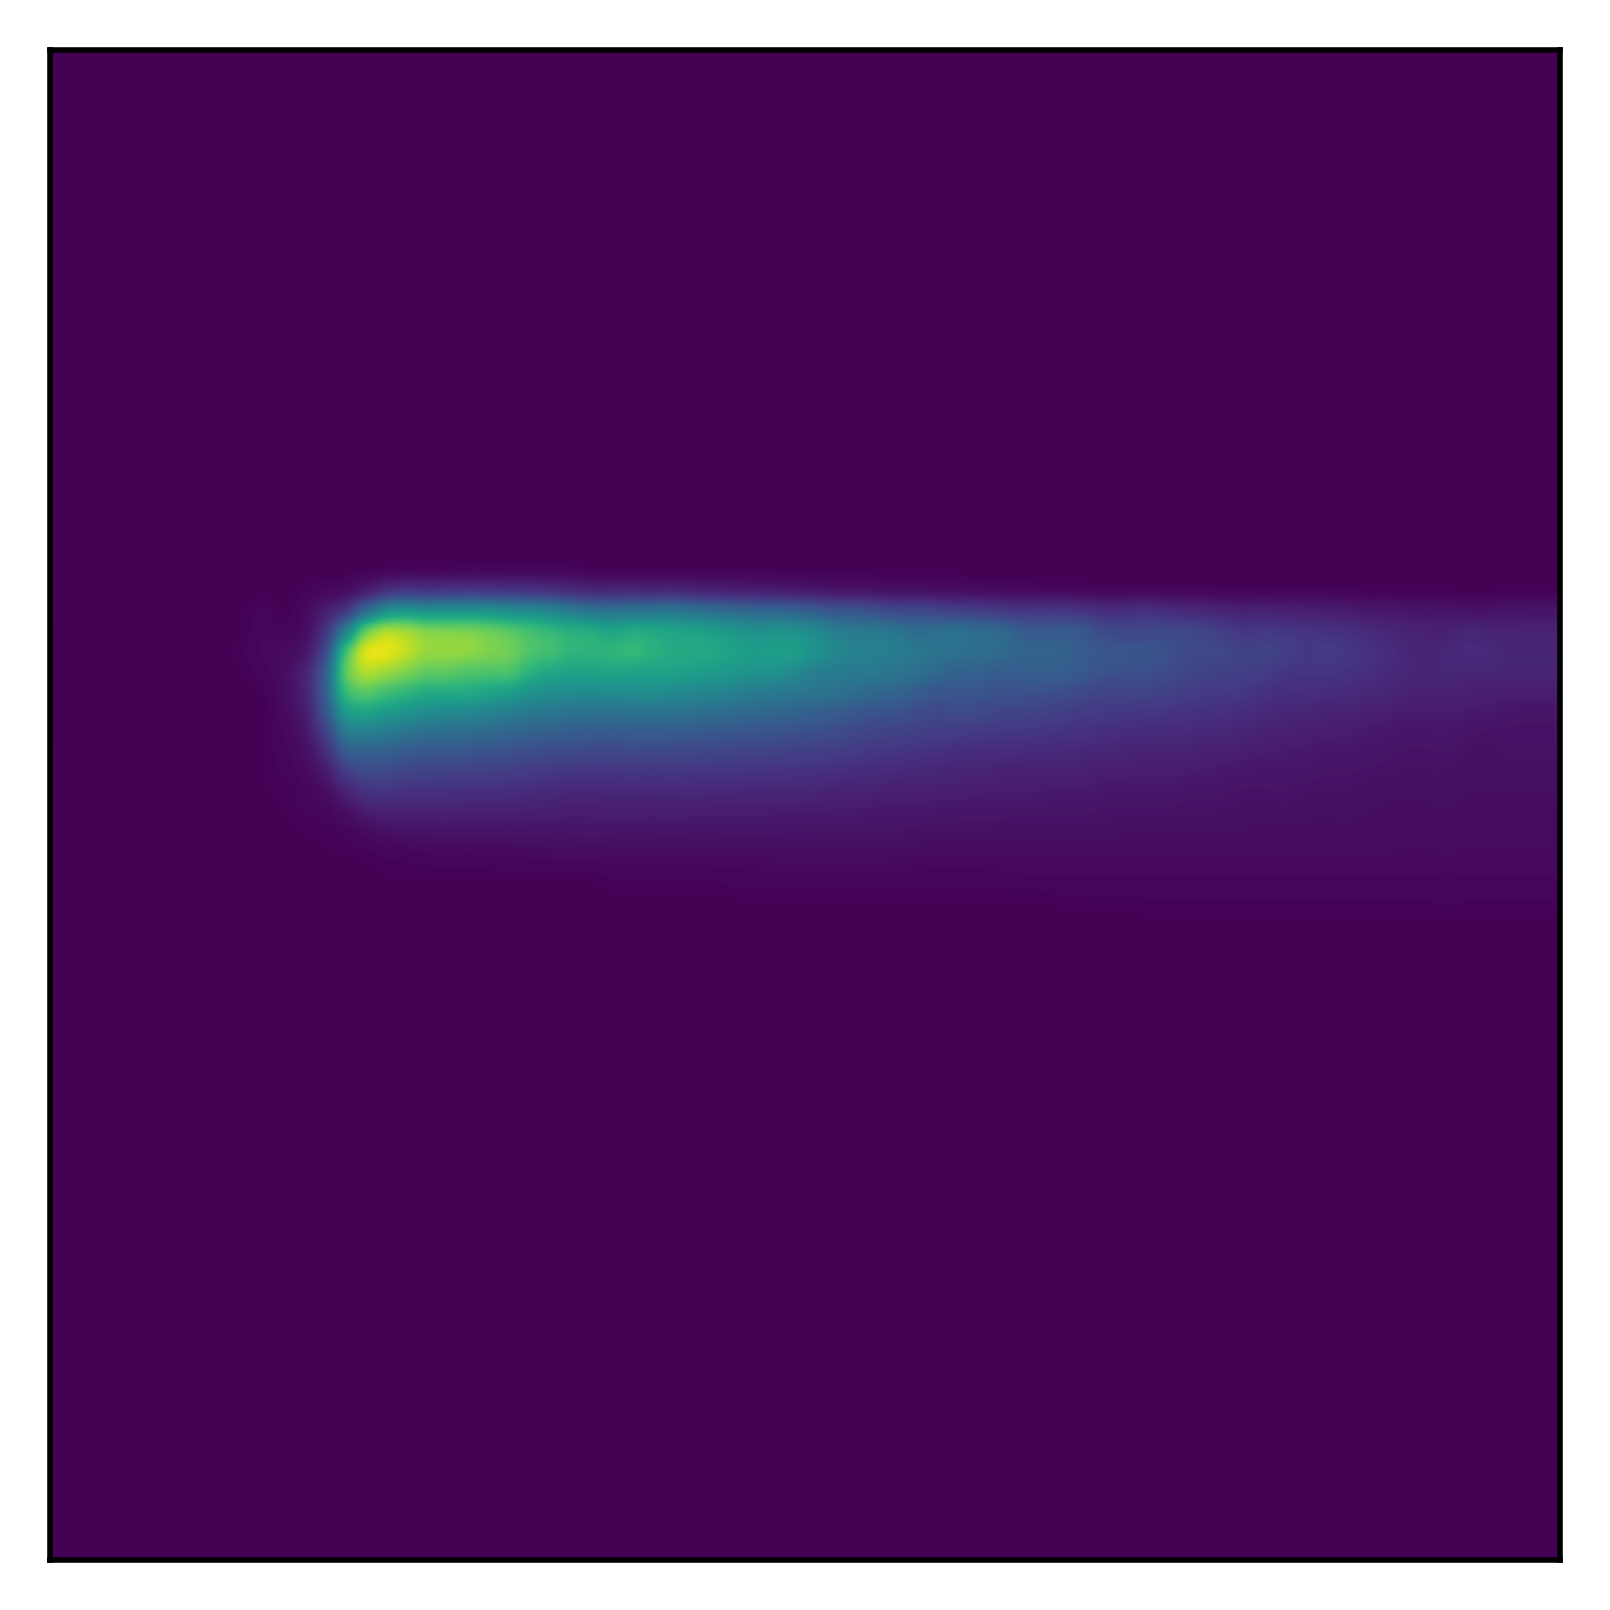

In [34]:
plt.figure(dpi=500)
plt.imshow(X_test[0].reshape(74,74),interpolation='gaussian');
plt.tick_params(left=False, bottom = False,labelleft=False,labelbottom=False);

In [35]:
train_predict = model.predict_classes(X_train)
val_predict = model.predict_classes(X_valid)
test_predict = model.predict_classes(X_test)

In [36]:
y_train_calss = np.argmax(y_train, axis = 1)
y_valid_calss = np.argmax(y_valid, axis = 1)
y_test_calss = np.argmax(y_test, axis = 1)

In [37]:
train_conf_matrix = tf.math.confusion_matrix(labels=y_train_calss, predictions=train_predict).numpy()
val_conf_matrix = tf.math.confusion_matrix(labels=y_valid_calss, predictions=val_predict).numpy()
test_conf_matrix = tf.math.confusion_matrix(labels=y_test_calss, predictions=test_predict).numpy()

In [38]:

train_conf_matrix = train_conf_matrix.astype('float') /train_conf_matrix.sum(axis=1)[:, np.newaxis]
val_conf_matrix  =  val_conf_matrix.astype('float') /  val_conf_matrix.sum(axis=1)[:, np.newaxis]
test_conf_matrix =  test_conf_matrix.astype('float') / test_conf_matrix.sum(axis=1)[:, np.newaxis]

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (4).

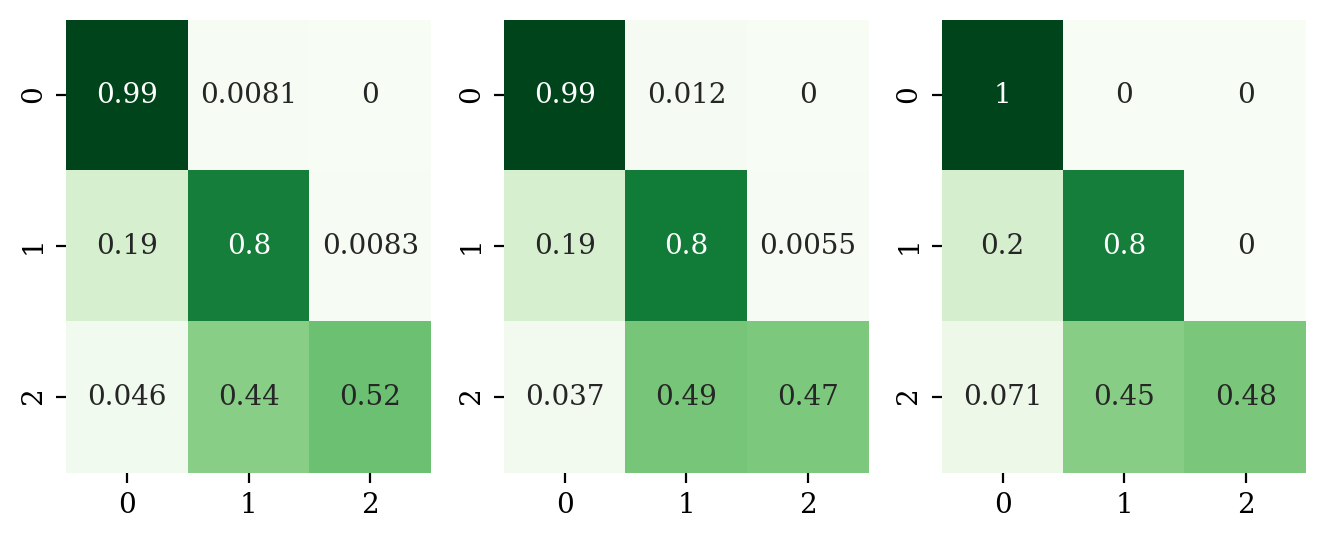

In [39]:
fig, ax = plt.subplots(1,3,figsize = (8,3), dpi=200)
sns.heatmap(train_conf_matrix, annot = True, cmap=plt.cm.Greens,ax=ax[0],cbar=False)
sns.heatmap(val_conf_matrix, annot = True, cmap=plt.cm.Greens,ax=ax[1],cbar=False)
sns.heatmap(test_conf_matrix, annot = True, cmap=plt.cm.Greens,ax=ax[2],cbar=False)
ax[0].set_xticklabels(labels,rotation = 45)
ax[1].set_xticklabels(labels,rotation = 45)
ax[2].set_xticklabels(labels,rotation = 45)
ax[0].set_yticklabels(labels,rotation = 45)
ax[0].set_ylabel('True Label')
ax[1].set_xlabel('Predicted label')
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])
ax[0].set_title('Training')
ax[1].set_title('Validation')
ax[2].set_title('Test')
plt.show()

In [ ]:
val_predict = model.predict_classes(X_valid)